In [64]:
import sys
sys.path.append('/Users/john/play/sports/') # add parent directory to path

In [65]:
from wrangle.join_datasets import load_the_historical_odds_df, join_the_odds_espn
import pandas as pd
import numpy as np
from db import base_db_interface

In [66]:
load_the_historical_odds_df().columns

Index(['FighterName', 'OpponentName', 'bookmaker_name', 'market_name',
       'commence_time', 'open_timestamp', 'home_team', 'away_team',
       'open_fighter_decimal_odds', 'open_opponent_decimal_odds',
       'close_timestamp', 'close_fighter_decimal_odds',
       'close_opponent_decimal_odds', 'FighterID', 'OpponentID', 'Date'],
      dtype='object')

In [109]:
def load_joined_datasets(bookmaker_name="DraftKings"):
    print("load bfo_espn_ufc_features")
    df = base_db_interface.read("bfo_espn_ufc_features")
    for dt_col in ["Date", "DOB", "DOB_opp"]:
        df[dt_col] = pd.to_datetime(df[dt_col])
    # df["FigherOpen"] = df["FighterOpen"].astype()
    df[["FighterOpen", "OpponentOpen"]] = df[["FighterOpen", "OpponentOpen"]]\
        .astype(float)
        
    df = df.drop_duplicates(subset=["fight_id"])
    #.dropna(subset=["FighterID_espn_espn", "OpponentID_espn"])
    df["FighterID_espn"] = df["FighterID_espn"].fillna("unknown")
    df["OpponentID_espn"] = df["OpponentID_espn"].fillna("unknown")
    print(df.shape)
    print("load the_odds_df")
    the_odds_df = load_the_historical_odds_df()
    print("load the_odds_to_espn_map")
    # the_odds_to_espn_map = base_db_interface.read("the_odds_espn_fighter_id_map")
    # the_odds_to_espn_map["Date_the_odds"] = \
    #     pd.to_datetime(the_odds_to_espn_map["Date_the_odds"])
    the_odds_to_espn_map = join_the_odds_espn()
    print("merge the_odds_to_espn_map with the_odds_df")
    the_odds_df = the_odds_df.merge(
        the_odds_to_espn_map,
        how='inner',
        left_on=["FighterID", "OpponentID", "Date"],
        right_on=["FighterID_the_odds", "OpponentID_the_odds", "Date_the_odds"]
    )
    # filter the_odds_df by bookmaker_name, drop irrelevant rows
    the_odds_df = the_odds_df.query(
        "bookmaker_name == '{bookmaker_name}' & market_name == 'h2h'".format(
            bookmaker_name=bookmaker_name
        )
    ).sort_values("commence_time")\
        .groupby(["FighterID_espn", "OpponentID_espn", "Date_espn"])\
        .last().reset_index()
    print(the_odds_df.shape, df.shape)
    print("merge the_odds_df with bfo_espn_ufc_features")
    df = df.merge(
        the_odds_df.drop(columns=[
            "FighterName", "OpponentName", "Date",
            # "FighterID_the_odds", "OpponentID_the_odds", "Date_the_odds"
            "FighterID", "OpponentID",
        ]),
        how='left',
        left_on=["FighterID_espn", "OpponentID_espn", "Date"],
        right_on=["FighterID_espn", "OpponentID_espn", "Date_espn"],
    )
    return df

df = load_joined_datasets(bookmaker_name="Betfair")
print(df.shape)
df.head()

load bfo_espn_ufc_features
(65514, 248)
load the_odds_df
load the_odds_to_espn_map
loading espn data
loading the-odds data
iteration 0 of 20. map has size 930 fighters mapped
frontier of map has size 29 fights
iteration 1 of 20. map has size 954 fighters mapped
frontier of map has size 2 fights
iteration 2 of 20. map has size 956 fighters mapped
frontier of map has size 0 fights
no more fights in frontier to add to map. map has size                       956 fighters mapped.                       154 fights left unaccounted for.
okay, now we finally include tournament fights
iteration 0 of 20. map has size 956 fighters mapped
iteration 1 of 20. map has size 1012 fighters mapped
iteration 2 of 20. map has size 1024 fighters mapped
no more fights to map. map has size                       1024 fighters mapped.                       92 fights left unaccounted for.
merge the_odds_to_espn_map with the_odds_df
(762, 22) (65514, 248)
merge the_odds_df with bfo_espn_ufc_features
(65514, 263)


,fight_id,Date,FighterResult,Decision,Rnd,Time,Event,OpponentID_espn,FighterID_espn,TSL,...,home_team,away_team,open_fighter_decimal_odds,open_opponent_decimal_odds,close_timestamp,close_fighter_decimal_odds,close_opponent_decimal_odds,FighterID_the_odds,OpponentID_the_odds,Date_the_odds
0,1991-09-26_2354059_2558095,1991-09-26,L,TKO (Injury),1,4:42,Desafio: Jiu-Jitsu vs. Luta Livre,2354059,2558095,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,1992-01-01_2354119_2501396,1992-01-01,W,Submission (Rear Naked Choke),1,7:03,Desafio: Gracie Vale Tudo,2501396,2354119,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,1993-08-29_2354132_3107994,1993-08-29,L,Submission (Strikes),1,2:46,CP X CB: Capoeira vs. Chute Boxe,2354132,3107994,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,1993-09-21_2335653_2557846,1993-09-21,L,Submission (Rear Naked Choke),1,6:15,"Pancrase: Yes, We Are Hybrid Wrestlers 1",2335653,2557846,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,1993-10-14_2335653_2431322,1993-10-14,L,Submission (Heel Hook),1,12:23,"Pancrase: Yes, We Are Hybrid Wrestlers 2",2335653,2431322,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [110]:
df["fight_id"].value_counts()

1991-09-26_2354059_2558095    1
2016-04-08_4397796_4401357    1
2016-04-08_3028399_3928693    1
2016-04-08_3892389_4056265    1
2016-04-08_3077836_4082117    1
                             ..
2011-06-05_4215817_4217378    1
2011-06-05_3032160_3084287    1
2011-06-05_2504806_3148979    1
2011-06-05_3104765_3941059    1
2023-04-15_2614933_3902098    1
Name: fight_id, Length: 65514, dtype: int64

In [111]:
df.query("fight_id == '2022-07-16_3089633_4076472'")[[
    "FighterID_the_odds", "OpponentID_the_odds", "Date_the_odds",
    "FighterID_espn", "OpponentID_espn", "Date_espn",
    "FighterName", "OpponentName", "close_fighter_decimal_odds",
    "close_opponent_decimal_odds", 
]]
# ah fuck, how does my model think Bill Algeo is Herbert Burns???

,FighterID_the_odds,OpponentID_the_odds,Date_the_odds,FighterID_espn,OpponentID_espn,Date_espn,FighterName,OpponentName,close_fighter_decimal_odds,close_opponent_decimal_odds
64539,Herbert Burns,Khusein Askhabov,2022-07-16,3089633,4076472,2022-07-16,herbert burns,bill algeo,3.1,1.38


In [112]:
# the_odds_to_espn_map = join_the_odds_espn()
# the_odds_to_espn_map

In [113]:
# okay how do I convert decimal odds to implied probability?
# and also to american odds

def decimal_to_implied_prob(decimal_odds):
    # decimal odds represent the payout if you bet $1
    return 1 / decimal_odds

def decimal_to_american_odds(decimal_odds):
    american_odds = pd.Series(np.nan, index=decimal_odds.index, dtype=float)
    fav_inds = decimal_odds < 2
    dog_inds = decimal_odds >= 2
    american_odds.loc[fav_inds] = -100 / (decimal_odds.loc[fav_inds] - 1)
    american_odds.loc[dog_inds] = 100 * (decimal_odds.loc[dog_inds] - 1)
    return american_odds
    
df["FighterOpen_implied_prob"] = decimal_to_implied_prob(df["open_fighter_decimal_odds"])
df["OpponentOpen_implied_prob"] = decimal_to_implied_prob(df["open_opponent_decimal_odds"])
df["open_fighter_american_odds"] = decimal_to_american_odds(df["open_fighter_decimal_odds"])
df["open_opponent_american_odds"] = decimal_to_american_odds(df["open_opponent_decimal_odds"])
df[[
    "FighterOpen_implied_prob",
    "OpponentOpen_implied_prob",
    "open_fighter_american_odds",
    "open_opponent_american_odds"
]].notnull().sum()

FighterOpen_implied_prob       369
OpponentOpen_implied_prob      369
open_fighter_american_odds     369
open_opponent_american_odds    369
dtype: int64

In [114]:
from sklearn.decomposition import PCA
# OKAY PCA HAPPENS HERE. Just do everything in-sample for now. 
stat_cols = [
    'TSL', 'TSA', 'SSL',
    'SSA', #'TSL-TSA', 
    'KD', #'%BODY', '%HEAD', '%LEG', 
    'SCBL',
    'SCBA', 'SCHL', 'SCHA', 'SCLL', 'SCLA', 'RV', 'TDL', 'TDA', 'TDS',
    # 'TK ACC', 'SR', # I don't believe in ratio features in PCA, 
    # # because of the possibility of division by zero and heteroskedasticity
    'SGBL', 'SGBA', 'SGHL', 'SGHA', 'SGLL', 'SGLA', 'AD', 'ADTB',
    'ADHG', 'ADTM', 'ADTS', 'SM', 'SDBL', 'SDBA', 'SDHL',
    'SDHA', 'SDLL', 'SDLA',
    #'time_seconds',
    # 'TD_fails', #'submission_rate',
    'TD_fail', # formerly 'TD_fails'
    'SDL', 'SCL', # formerly 'distance_strikes_landed', 'clinch_strikes_landed',
    #'KD_power', 
    'SGL', # formerly 'ground_strikes_landed'
]
df[["KD", "KD_opp"]] = df[["KD", "KD_opp"]].astype(float) 
# convert from string to float. rather annoying

In [286]:
# n_pca = 14
# bin_elo_alpha = 0.45
# acc_elo_alpha = 0.45
# pca_elo_alpha = 0.45

n_pca = 14
bin_elo_alpha = 0.85
acc_elo_alpha = 0.85
pca_elo_alpha = 0.85

In [287]:
stat_diff_df = {
    "FighterID_espn": df["FighterID_espn"],
    "OpponentID_espn": df["OpponentID_espn"],
    "Date": df["Date"],
    "gender": df["gender"],
    "fight_id": df["fight_id"],
}
diff_cols = [col+"_diff" for col in stat_cols]
for col, diff_col in zip(stat_cols, diff_cols):
    stat_diff_df[diff_col] = (
        np.sqrt(df[col]) - np.sqrt(df[col+"_opp"])
    ) # TODO try fillna(0)
# stat_diff_df = pd.DataFrame(stat_diff_df).dropna(subset=diff_cols).reset_index()
stat_diff_df = pd.DataFrame(stat_diff_df).reset_index()

In [288]:
from model.mma_features import PcaEloWrapper, BinaryEloWrapper

pca_ew = PcaEloWrapper(
    n_pca=n_pca, target_cols=diff_cols, alpha=pca_elo_alpha,
    conditional_var_col=None, # for consistency
)
pca_elo_feat_df = pca_ew.fit_transform_all(stat_diff_df)
pca_elo_feat_df

getting elo features for PC_0


100%|██████████| 1684/1684 [00:30<00:00, 54.76it/s]


getting elo features for PC_1


100%|██████████| 1684/1684 [00:30<00:00, 54.63it/s]


getting elo features for PC_2


100%|██████████| 1684/1684 [00:43<00:00, 38.29it/s]


getting elo features for PC_3


100%|██████████| 1684/1684 [00:43<00:00, 38.70it/s]


getting elo features for PC_4


100%|██████████| 1684/1684 [00:43<00:00, 39.01it/s]


getting elo features for PC_5


100%|██████████| 1684/1684 [00:43<00:00, 38.72it/s]


getting elo features for PC_6


100%|██████████| 1684/1684 [00:44<00:00, 38.14it/s]


getting elo features for PC_7


100%|██████████| 1684/1684 [00:42<00:00, 39.44it/s]


getting elo features for PC_8


100%|██████████| 1684/1684 [00:42<00:00, 39.77it/s]


getting elo features for PC_9


100%|██████████| 1684/1684 [00:42<00:00, 39.86it/s]


getting elo features for PC_10


100%|██████████| 1684/1684 [00:44<00:00, 37.95it/s]


getting elo features for PC_11


100%|██████████| 1684/1684 [00:30<00:00, 54.36it/s]


getting elo features for PC_12


100%|██████████| 1684/1684 [00:43<00:00, 39.02it/s]


getting elo features for PC_13


100%|██████████| 1684/1684 [00:42<00:00, 39.20it/s]


,fight_id,pred_PC_0,pred_PC_1,pred_PC_2,pred_PC_3,pred_PC_4,pred_PC_5,pred_PC_6,pred_PC_7,pred_PC_8,pred_PC_9,pred_PC_10,pred_PC_11,pred_PC_12,pred_PC_13
0,1991-09-26_2354059_2558095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1992-01-01_2354119_2501396,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1993-08-29_2354132_3107994,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1993-09-21_2335653_2557846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1993-10-14_2335653_2431322,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65509,2023-04-08_4285679_4705658,-0.216553,-0.577267,1.344784,1.247287,0.431476,-0.306186,-1.040742,0.049881,1.466773,-1.383533,-1.234374,-1.031083,0.935241,0.219472
65510,2023-04-08_2960757_3952937,-0.051293,-0.180608,0.895025,0.230791,0.447960,-1.048518,-0.716821,-0.202513,-0.463816,1.304191,-0.655525,-0.470921,-0.305629,-0.541012
65511,2023-04-08_3023804_4781218,-0.363980,0.056950,0.273059,1.013957,1.045993,1.086990,0.218141,-0.986897,-0.785523,0.101604,-0.867590,-1.507397,1.118529,0.410235
65512,2023-04-08_3090451_3998248,0.530542,-1.412149,0.222387,-0.317906,2.987994,1.271734,-1.418670,-0.184075,-0.561213,0.470553,2.321208,1.518587,0.095068,0.173797


In [289]:
df.columns[df.columns.str.lower().str.contains("decision")]

Index(['Decision', 'decision_clean', 'decision_fighter_result'], dtype='object')

## Result of the fight

In [290]:
df["decision_clean"].value_counts()

tko/ko                  23942
submission              20799
decision - unanimous    15098
decision - split         3857
draw                      804
nc                        408
                          338
dq                        237
technical decision         31
Name: decision_clean, dtype: int64

In [291]:
df["decision_clean"].isnull().mean()

0.0

In [292]:
def parse_decision(s):
    if (s.startswith("submission") or 
        s.startswith("sumission") or
        s.startswith("technical submission")
    ):
        return "submission"
    if (s.startswith("tko") or 
        s.startswith("ko") or
        (s == 'could not continue')
    ):
        return "tko_ko"
    if "decision" in s:
        return "decision"
    return "other"

temp_decision = df["Decision"].fillna("-").str.lower().str.strip()
decision_clean = temp_decision.apply(parse_decision)
result_sign = df["FighterResult"].map({"W": 1, "L":-1, "D": 0})
decision_score = decision_clean.map({"tko_ko":2, "submission":2, 
                                                    "decision":1, "other":0})
df["ordinal_fighter_result"] = result_sign * decision_score
submission_score = decision_clean.map({"submission":1, "decision":0, 
                                            "other":0, "tko_ko":0})
tko_ko_score = decision_clean.map({"submission":0, "decision":0, 
                                            "other":0, "tko_ko":1})
decision_score = decision_clean.map({"submission":0, "decision":1, 
                                            "other":0, "tko_ko":0})
finish_score = decision_clean.map({"submission":1, "decision":0, 
                                            "other":0, "tko_ko":1})
df["submission_fighter_result"] = result_sign * submission_score
df["tko_ko_fighter_result"] = result_sign * tko_ko_score
df["decision_fighter_result"] = result_sign * decision_score
df["finish_fighter_result"] = result_sign * finish_score

In [293]:
df["win_target"] = df["FighterResult"].replace({"W":1, "L":0, "D":np.nan})
df["win_target_finish"] = df["win_target"] * decision_clean.map({
    "submission":1, "tko_ko":1,
    "decision":np.nan, "other":np.nan, 
})
df["win_target_finish"].value_counts()

0.0    22380
1.0    22361
Name: win_target_finish, dtype: int64

In [294]:
from model.mma_features import RealEloWrapper

real_elo_target_cols = [
#     "fighter_result_time_left", 
#     "ml_logit_mvmt",
    # "ordinal_fighter_result",
    # "submission_fighter_result",
    # "tko_ko_fighter_result",
    # "decision_fighter_result",
    # "finish_fighter_result",
]
diff_elo_target_cols = [
]

binary_elo_target_cols = ["win_target", "win_target_finish"]

elo_alphas = {
    col: 0.45 for col in (real_elo_target_cols + diff_elo_target_cols)
}
# elo_alphas["ml_logit_mvmt"] = 0.225

real_ew = RealEloWrapper(elo_alphas=elo_alphas)
real_elo_feat_df = real_ew.fit_transform_all(df)
print(real_elo_feat_df.shape)
real_elo_feat_df.head()

elo_alphas = {
    col: 0.45 for col in binary_elo_target_cols
}
bin_ew = BinaryEloWrapper(elo_alphas=elo_alphas)
bin_elo_feat_df = bin_ew.fit_transform_all(df)
print(bin_elo_feat_df.shape)
bin_elo_feat_df.head()
# feat_ml_df["log_height_diff"] = np.log(feat_ml_df["imp_height"]) - np.log(feat_ml_df["imp_height_opp"])
# feat_ml_df["log_age_diff"] = np.log(feat_ml_df["age"]) - np.log(feat_ml_df["age_opp"])
# feat_ml_df["log_reach_diff"] = np.log(feat_ml_df["imp_reach"]) - np.log(feat_ml_df["imp_reach_opp"])
# feat_ml_df["log_reach_diff"] = feat_ml_df["log_reach_diff"].fillna(0)

(65514, 1)
getting elo features for win_target


100%|██████████| 65514/65514 [00:22<00:00, 2889.07it/s]


getting elo features for win_target_finish


100%|██████████| 65514/65514 [00:22<00:00, 2876.57it/s]

(65514, 5)


,fight_id,pred_win_target,pred_win_target_logit,pred_win_target_finish,pred_win_target_finish_logit
0,1991-09-26_2354059_2558095,0.500000,0.0000,0.500000,0.0000
1,1992-01-01_2354119_2501396,0.500000,0.0000,0.500000,0.0000
2,1993-08-29_2354132_3107994,0.500000,0.0000,0.500000,0.0000
3,1993-09-21_2335653_2557846,0.500000,0.0000,0.500000,0.0000
4,1993-10-14_2335653_2431322,0.471905,-0.1125,0.471905,-0.1125


In [295]:
feat_ml_df = df.merge(
    pca_elo_feat_df, 
    how="left", 
    on=["fight_id"]
).merge(
    real_elo_feat_df,
    how="left",
    on=["fight_id"]
).merge(
    bin_elo_feat_df,
    how="left",
    on=["fight_id"]
)

In [296]:
feat_ml_df.columns[feat_ml_df.columns.str.lower().str.contains("t_since_last")]

Index([], dtype='object')

In [297]:
from model.mma_elo_model import unknown_fighter_id
from tqdm import tqdm


def _get_simple_features(df):
    # simple things that i needn't get from the fighter stats page
    # eg number of fights, t_since_last_fight
    df = df.assign(
        is_ufc=df["Event"].fillna("").str.contains("UFC"),
        Date=pd.to_datetime(df["Date"]),
    )
    df = df.sort_values("Date")
    fighters = set(df["FighterID_espn"]) | set(df["OpponentID_espn"])
    total_fight_counter = pd.Series(0, index=sorted(fighters))
    total_ufc_fight_counter = pd.Series(0, index=sorted(fighters))
    last_fight_counter = pd.Series(pd.to_datetime("1900-01-01"), index=sorted(fighters))
    # arbitrary date to start with - like starting with np.inf
    first_fight_dt_map = pd.Series(pd.to_datetime("2100-01-01"), index=sorted(fighters))
    feat_df_list = [] # concat this at the end
    for curr_dt, grp in tqdm(df.groupby("Date")):
        fid_vec = grp["FighterID_espn"]
        oid_vec = grp["OpponentID_espn"]
        is_ufc = grp["is_ufc"]
        first_fight_dt_map[fid_vec] = np.minimum(pd.Series(curr_dt, index=fid_vec), 
                                                    first_fight_dt_map[fid_vec])
        first_fight_dt_map[oid_vec] = np.minimum(pd.Series(curr_dt, index=oid_vec), 
                                                    first_fight_dt_map[oid_vec])
        feat_df_list.append(pd.DataFrame({
            "FighterID_espn":fid_vec,
            "OpponentID_espn":oid_vec,
            "Date":grp["Date"],
            "total_fights":fid_vec.map(total_fight_counter),
            "total_ufc_fights":fid_vec.map(total_ufc_fight_counter),
            "t_since_last_fight":(curr_dt - fid_vec.map(last_fight_counter)).dt.days,
            # "t_since_first_fight":(curr_dt - fid_vec.map(first_fight_dt_map)).dt.days,
            "total_fights_opp":oid_vec.map(total_fight_counter),
            "total_ufc_fights_opp":oid_vec.map(total_ufc_fight_counter),
            "t_since_last_fight_opp":(curr_dt - oid_vec.map(last_fight_counter)).dt.days,
            # "t_since_first_fight_opp":(curr_dt - oid_vec.map(first_fight_dt_map)).dt.days,
        }))
        # if somehow this guy takes multiple fights in the same day,
        # just count it as one fight. 
        total_fight_counter[fid_vec] += 1
        total_fight_counter[oid_vec] += 1
        last_fight_counter[fid_vec] = curr_dt
        last_fight_counter[oid_vec] = curr_dt
        ufc_grp = grp.loc[is_ufc]
        total_ufc_fight_counter[ufc_grp["FighterID_espn"]] += 1
        total_ufc_fight_counter[ufc_grp["OpponentID_espn"]] += 1
        # make sure unknown_fighter_id stays unknown!
        total_fight_counter[unknown_fighter_id] = 0
        total_ufc_fight_counter[unknown_fighter_id] = 0
        last_fight_counter[unknown_fighter_id] = pd.to_datetime("1900-01-01")
        first_fight_dt_map[unknown_fighter_id] = curr_dt
    feat_df = pd.concat(feat_df_list)
    # cap t_since_last_fight, which can go really long
    # note that because last_fight_counter is initialized to a really early date,
    # this will handle the case where total_fights=0
    feat_df["t_since_last_fight"] = np.minimum(2*365, feat_df["t_since_last_fight"])
    feat_df["t_since_last_fight_opp"] = np.minimum(2*365, feat_df["t_since_last_fight_opp"])
    # compute diffs (idk how i want to --- this...)
    feat_df["t_since_last_fight_diff"] = (feat_df["t_since_last_fight"] - 
                                            feat_df["t_since_last_fight_opp"])
    feat_df["t_since_last_fight_log_diff"] = (np.log(feat_df["t_since_last_fight"]) - 
                                                np.log(feat_df["t_since_last_fight_opp"]))
    feat_df["total_fights_diff"] = (feat_df["total_fights"] - 
                                    feat_df["total_fights_opp"])
    feat_df["total_fights_sqrt_diff"] = (np.sqrt(feat_df["total_fights"]) - 
                                        np.sqrt(feat_df["total_fights_opp"]))
    feat_df["total_ufc_fights_diff"] = (feat_df["total_ufc_fights"] - 
                                        feat_df["total_ufc_fights_opp"])
    feat_df["total_ufc_fights_sqrt_diff"] = (np.sqrt(feat_df["total_ufc_fights"]) - 
                                                np.sqrt(feat_df["total_ufc_fights_opp"]))
    # feat_df["t_since_first_fight_diff"] = (feat_df["t_since_first_fight"] -
    #                                         feat_df["t_since_first_fight_opp"])
    # feat_df["t_since_first_fight_log_diff"] = (np.log(feat_df["t_since_first_fight"]) -
    #                                             np.log(feat_df["t_since_first_fight_opp"]))
    return feat_df

simple_feat_df = _get_simple_features(feat_ml_df)
print(simple_feat_df.shape, feat_ml_df.shape)

100%|██████████| 5143/5143 [00:38<00:00, 132.78it/s]


(65514, 15) (65514, 292)


In [298]:
feat_ml_df.columns[feat_ml_df.columns.str.contains("Name")]

Index(['FighterName', 'OpponentName', 'FighterName_ufc', 'OpponentName_ufc',
       'FighterName_bfo', 'OpponentName_bfo'],
      dtype='object')

In [486]:
feat_ml_df = feat_ml_df.merge(
    simple_feat_df, 
    how="left",
    on=["FighterID_espn", "OpponentID_espn", "Date"]
)

feat_ml_df["age_diff"] = (feat_ml_df["DOB"] - feat_ml_df["DOB_opp"]).dt.days / 365
feat_ml_df["age_diff"] = feat_ml_df["age_diff"].fillna(0)

feat_ml_df["log_reach_diff"] = (
    np.log(feat_ml_df["ReachInches"]) - np.log(feat_ml_df["ReachInches_opp"])
).fillna(0)
feat_ml_df["weight_diff"] = (
    feat_ml_df["min_weight"] - feat_ml_df["min_weight_opp"]
).fillna(0)
feat_ml_df["height_diff"] = (
    feat_ml_df["HeightInches"] - feat_ml_df["HeightInches_opp"]
).fillna(0)
# feat_ml_df["reach_diff"] = feat_ml_df["imp_reach"] - feat_ml_df["imp_reach_opp"]
# feat_ml_df["log_reach_diff"] = np.log(feat_ml_df["imp_reach"]) - np.log(feat_ml_df["imp_reach_opp"])
# feat_ml_df["weight_diff"] = feat_ml_df["imp_weight"] - feat_ml_df["imp_weight_opp"]
# feat_ml_df["log_weight_diff"] = np.log(feat_ml_df["imp_weight"]) - np.log(feat_ml_df["imp_weight_opp"])
# feat_ml_df["height_diff"] = feat_ml_df["imp_height"] - feat_ml_df["imp_height_opp"]

feat_ml_df["t_since_first_fight_diff"] = (
    feat_ml_df["t_since_first_fight"] - feat_ml_df["t_since_first_fight_opp"]
).fillna(0)
feat_ml_df["log_t_since_first_fight_diff"] = (
    np.log(1 + feat_ml_df["t_since_first_fight"]) - 
    np.log(1 + feat_ml_df["t_since_first_fight_opp"])
).fillna(0)

feat_ml_df["log_t_since_prev_fight_diff"] = (
    np.log(1 + feat_ml_df["t_since_prev_fight"]) -
    np.log(1 + feat_ml_df["t_since_prev_fight_opp"])
).fillna(0)

# money line features
# feat_ml_df["ml_mvmt"] = 
#         .str.replace("▼", "").str.replace("▲", "").astype(float)
# ml_increased = feat_ml_df["DraftKings_fighter"].str.endswith("▲")
# ml_decreased = feat_ml_df["DraftKings_fighter"].str.endswith("▼")
# feat_ml_df["ml_mvmt"] =(
#     ml_increased.fillna(0).astype(int) - 
#     ml_decreased.fillna(0).astype(int)
# )

feat_ml_df["is_main_event"] = feat_ml_df["fight_rank_on_card"] == 1



real_elo_target_cols = [
#     "fighter_result_time_left", 
#     "ml_logit_mvmt",
#     "ordinal_fighter_result",
#     "submission_fighter_result",
#     "tko_ko_fighter_result",
#     "decision_fighter_result",
    # "finish_fighter_result",
    # *[col for col in stat_pca_df.columns 
    #   if col not in ["FighterID_espn", "OpponentID_espn", "Date"]],
]

feat_cols = [
    # *[f"pred_PC_{i}" for i in range(n_pca)],
'pred_PC_0',
 'pred_PC_1',
 'pred_PC_2',
 'pred_PC_3',
 'pred_PC_4',
 'pred_PC_5',
 'pred_PC_6',
 'pred_PC_7',
 'pred_PC_8',
 'pred_PC_9',
 'pred_PC_10',
 'pred_PC_11',
 'pred_PC_12',
 'pred_PC_13',

    *["pred_"+c for c in [*diff_elo_target_cols, 
                               *real_elo_target_cols, 
                               *binary_elo_target_cols]],
    
    # "t_since_last_fight_log_diff", 
#     "fights_per_day_diff",
#     "t_since_last_fight_diff",
#     "total_fights_sqrt_diff", 
#     "total_ufc_fights_diff",
    
    "age_diff", 
#     "log_age_diff",
#     "reach_diff", 
    "log_reach_diff",
    "weight_diff", 
#     "log_weight_diff",
    "height_diff",
#     "log_height_diff",
#     "ml_logit_mvmt",
    "log_t_since_prev_fight_diff",
#     "quad_log_t_since_first_fight_diff",

    # "ml_mvmt",
]

# new_feat_cols = [*feat_cols, "ml_logit"]
feat_cols

['pred_PC_0',
 'pred_PC_1',
 'pred_PC_2',
 'pred_PC_3',
 'pred_PC_4',
 'pred_PC_5',
 'pred_PC_6',
 'pred_PC_7',
 'pred_PC_8',
 'pred_PC_9',
 'pred_PC_10',
 'pred_PC_11',
 'pred_PC_12',
 'pred_PC_13',
 'pred_win_target',
 'pred_win_target_finish',
 'age_diff',
 'log_reach_diff',
 'weight_diff',
 'height_diff',
 'log_t_since_prev_fight_diff']

In [487]:
feat_ml_df[feat_cols].notnull().sum()

pred_PC_0                      65514
pred_PC_1                      65514
pred_PC_2                      65514
pred_PC_3                      65514
pred_PC_4                      65514
pred_PC_5                      65514
pred_PC_6                      65514
pred_PC_7                      65514
pred_PC_8                      65514
pred_PC_9                      65514
pred_PC_10                     65514
pred_PC_11                     65514
pred_PC_12                     65514
pred_PC_13                     65514
pred_win_target                65514
pred_win_target_finish         65514
age_diff                       65514
log_reach_diff                 65514
weight_diff                    65514
height_diff                    65514
log_t_since_prev_fight_diff    65514
dtype: int64

In [488]:
feat_ml_df["finish_fighter_result"].notnull().mean()

0.9988552065207437

In [489]:
feat_ml_df[["pred_PC_0", "pred_PC_1", 
            "pred_win_target_finish"]].notnull().all(1).sum()

65514

In [490]:
feat_ml_df[feat_cols].notnull().all(1).sum()

65514

In [491]:
from model.mma_log_reg_stan import SimpleSymmetricModel

mod = SimpleSymmetricModel(feat_cols=feat_cols, target_col="win_target", 
                           p_fighter_implied_col="FighterOpen_implied_prob",
                        # p_fighter_implied_col="p_fighter_open_implied",
                        #    beta_prior_std=1.0, 
                            beta_prior_std=0.1,
                           mcmc=False)
# y_hat = mod.fit_predict(train_df, test_df)
# y_hat.shape

In [492]:
feat_ml_df.columns[feat_ml_df.columns.str.contains("p_fighter")]

Index(['p_fighter_open_implied', 'p_fighter_close_implied'], dtype='object')

In [493]:
from model_selection.cross_val_pipeline import TimeSeriesCrossVal

tscv = TimeSeriesCrossVal(min_test_date=pd.to_datetime("2021-01-01"), 
                          n_dates_per_fold=1, 
                          p_fighter_implied_col="FighterOpen_implied_prob")
preds_df = tscv.get_cross_val_preds(
    mod, 
    feat_ml_df.dropna(subset=[
        *feat_cols, "win_target", "FighterOpen_implied_prob"
    ])#.query("is_ufc == 1")
)

training on date range: 2021-06-12 2021-06-12
Initial log joint probability = -1300.85
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       5      -2.94983   3.27843e-05   1.10771e-05           1           1        6   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
training on date range: 2021-06-12 2021-06-19
Initial log joint probability = -1821.17
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       5      -7.96722   0.000341387   0.000496407           1           1        6   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
training on date range: 2021-06-12 2021-06-26
Initial log joint probability = -977.092
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       5      -10.4341   0.000184548   0.000377979           1           1   

In [494]:
(preds_df["y_pred"].round() == preds_df["win_target"]).mean()

0.6526610644257703

In [495]:
(preds_df["FighterOpen_implied_prob"].round() == preds_df["win_target"]).mean()

0.6442577030812325

In [496]:
from sklearn.metrics import log_loss

temp_preds_df = preds_df.dropna(subset=[
    "y_pred", "win_target", "FighterOpen_implied_prob"])

xce = log_loss(y_true=temp_preds_df["win_target"], y_pred=temp_preds_df["y_pred"])
xce_ml = log_loss(y_true=temp_preds_df["win_target"], y_pred=temp_preds_df["FighterOpen_implied_prob"])

print(f"model log loss: {xce}")
print(f"opening money line log loss: {xce_ml}")

model log loss: 0.6433878876221624
opening money line log loss: 0.6339272127394134


In [497]:
preds_df["week"] = preds_df["Date"].dt.isocalendar().week

overall winnings


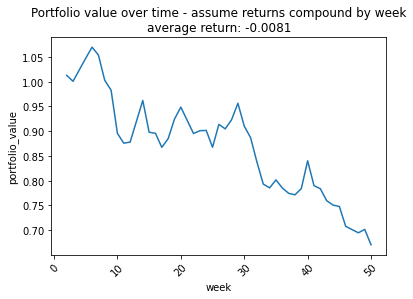

ufc winnings


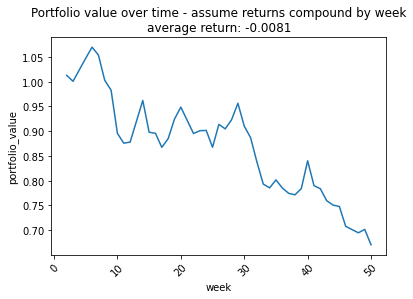

In [498]:
from model_selection.metrics import MultiKellyPM

def plot_pm_dk(preds_df):
    pm = MultiKellyPM(
        preds_df, max_bankroll_fraction=1, groupby_col="week",
        fighter_ml_col="open_fighter_american_odds",
        opponent_ml_col="open_opponent_american_odds",
    )
    event_return_df = pm.get_all_returns()
    pm.plot_diagnostics(event_return_df, x_col="week")
    return event_return_df

print("overall winnings")
overall_return_df = plot_pm_dk(preds_df)

print("ufc winnings")
ufc_return_df = plot_pm_dk(preds_df.query("is_ufc == 1"))

# print("non-ufc winnings")
# non_ufc_return_df = plot_pm_dk(preds_df.query("is_ufc == 0"))

In [499]:
# feat_ml_df.loc[feat_ml_df["pred_PC_0"].notnull(), 
#                "finish_fighter_result"].isnull().mean()

In [500]:
dict(zip(feat_cols, mod.fit["beta"]))

{'pred_PC_0': 0.0017468375440601628,
 'pred_PC_1': -0.0027777545508611647,
 'pred_PC_2': 0.013296151589122817,
 'pred_PC_3': 0.03805430843251568,
 'pred_PC_4': 0.057472639268089674,
 'pred_PC_5': 0.006694494494210163,
 'pred_PC_6': -0.02611203876985659,
 'pred_PC_7': 0.029480037032480828,
 'pred_PC_8': 0.00614443546995813,
 'pred_PC_9': 0.001891815761230309,
 'pred_PC_10': 0.017118859153130446,
 'pred_PC_11': -0.0018725519644475948,
 'pred_PC_12': 0.05734115331028143,
 'pred_PC_13': -0.08149075115473858,
 'pred_win_target': -0.045164759348514716,
 'pred_win_target_finish': -0.044219083438203896,
 'age_diff': 0.010457405522275682,
 'log_reach_diff': 0.0902486512960665,
 'weight_diff': -0.03448100328676825,
 'height_diff': 4.600998636249407e-05,
 'log_t_since_prev_fight_diff': 0.04994953694521948}

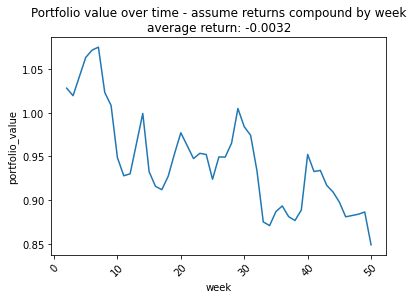

In [501]:
from scipy.special import expit, logit

model_adj = logit(preds_df["y_pred"]) - \
    logit(preds_df["FighterOpen_implied_prob"])
model_adj = model_adj.clip(-0.2, 0.2)
log_odds_adj = model_adj + logit(preds_df["FighterOpen_implied_prob"])

clipped_preds_df = preds_df.assign(
    y_pred=expit(log_odds_adj)
)

clipped_return_df = plot_pm_dk(clipped_preds_df)

In [502]:
preds_df["Event"].str.lower().str.contains("fight night").mean()

0.6918767507002801

In [503]:
preds_df["event_contains_title_fight"] = preds_df["Event"].str.lower().str.contains("title fight")

In [504]:
preds_df.columns[preds_df.columns.str.contains("title")]

Index(['is_title_fight', 'event_contains_title_fight'], dtype='object')

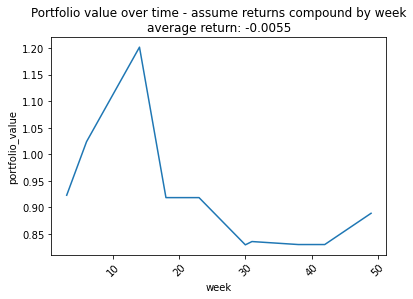

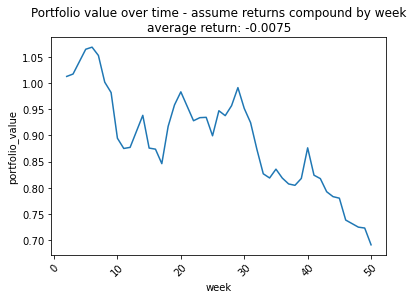

In [505]:
title_fight_return_df = plot_pm_dk(
    preds_df.query("is_title_fight == 1")
)

non_title_fight_return_df = plot_pm_dk(
    preds_df.query("is_title_fight == 0")
)

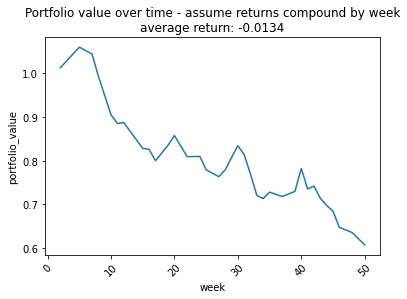

In [506]:
fight_night_return_df = plot_pm_dk(
    preds_df.query("Event.str.lower().str.contains('fight night')")
)

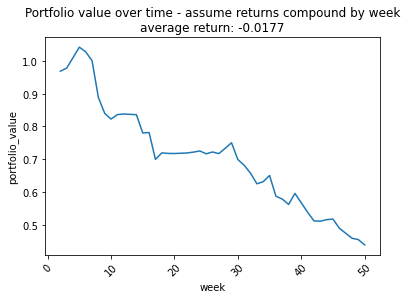

In [507]:
# so far, this is my best realistic performance
undercard_return_df = plot_pm_dk(
    preds_df.query("fight_rank_on_card >= 5 & is_ufc == 1")
)

In [508]:
# sharpe ratio
undercard_return_df["return"].mean() / (undercard_return_df["return"].std() / np.sqrt(40))

-2.7721700024619462

In [509]:
# # preds_df["fight_rank_on_card"]
# for i, grp in preds_df.groupby("fight_rank_on_card"):
#     # print(i, (grp["y_pred"].round() == grp["win_target"]).mean())
#     print(i, log_loss(
#         y_true=grp["win_target"], y_pred=grp["y_pred"]
#     ))
#     # plot_pm_dk(grp)

In [510]:
log_loss(y_true=preds_df["win_target"], y_pred=preds_df["y_pred"])

0.6433878876221624

In [511]:
df.columns[-30:]

Index(['total_ufc_cage_time_opp', 'min_weight_opp', 'max_weight_opp',
       'prev_weight_opp', 'Date_espn', 'bookmaker_name', 'market_name',
       'commence_time', 'open_timestamp', 'home_team', 'away_team',
       'open_fighter_decimal_odds', 'open_opponent_decimal_odds',
       'close_timestamp', 'close_fighter_decimal_odds',
       'close_opponent_decimal_odds', 'FighterID_the_odds',
       'OpponentID_the_odds', 'Date_the_odds', 'FighterOpen_implied_prob',
       'OpponentOpen_implied_prob', 'open_fighter_american_odds',
       'open_opponent_american_odds', 'ordinal_fighter_result',
       'submission_fighter_result', 'tko_ko_fighter_result',
       'decision_fighter_result', 'finish_fighter_result', 'win_target',
       'win_target_finish'],
      dtype='object')

Seems like there's no relationship btw time till the fight starts and my accuracy

<AxesSubplot:xlabel='log_t_till_commence', ylabel='log_loss'>

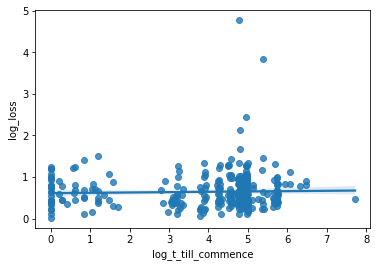

In [512]:
import seaborn as sns

preds_df["t_till_commence"] = (
    pd.to_datetime(preds_df["commence_time"]) - 
    pd.to_datetime(preds_df["open_timestamp"])
).dt.total_seconds() / 3600
preds_df["log_t_till_commence"] = np.log(
    preds_df["t_till_commence"].clip(1, np.inf)
)

preds_df["log_loss"] = -1 * (
    preds_df["win_target"] * np.log(preds_df["y_pred"]) +
    (1 - preds_df["win_target"]) * np.log(1 - preds_df["y_pred"])
)

sns.regplot(data=preds_df,#.query("t_till_commence < 500"), 
                x="log_t_till_commence", y="log_loss",
                # logx=True
)


<AxesSubplot:xlabel='fight_rank_on_card', ylabel='log_loss'>

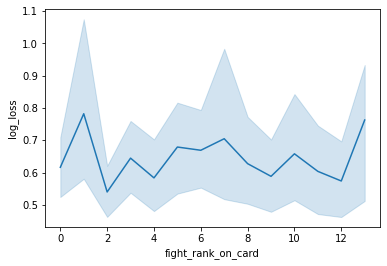

In [513]:
sns.lineplot(data=preds_df,
                x="fight_rank_on_card", y="log_loss")

<AxesSubplot:xlabel='y_pred', ylabel='log_loss'>

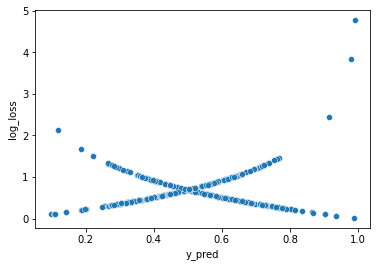

In [514]:
# pretty sure this is the graph we'd expect to see
sns.scatterplot(data=preds_df,#.query("t_till_commence < 500"), 
                x="y_pred", y="log_loss",
                # logx=True
)

In [515]:
df.columns[df.columns.str.contains("STANCE")]


Index([], dtype='object')